### 数据导入

In [1]:
# 选择需要的因子
indicators = [
    "macd", "bbi", "ad", "ama", "pdi","mdi", 'mom',"sar",
    "kdj", "rsi", "roc", "bias", "cci", "osc", "cmo", "apo", 'ao',
     "bopa", "mfi", "wr", 'tema', 'vhf', 'cmf', 'vris', 'k', 'd', 'ri', 'cvi','obv']

rolling_window = 252
contract = 'T' #可换为T、TL、TF


In [2]:
# 滚动窗口更新信号并应用
import os
import pandas as pd
# 设置文件路径
file_path = f'rolling_data_{contract}_{rolling_window}.csv'# 如果文件已存在，加载已保存的数据
rolling_signal = pd.read_csv(file_path)
rolling_signal['date'] = pd.to_datetime(rolling_signal.date)

file_path = f'signal_data_{contract}.csv'# 如果文件已存在，加载已保存的数据
signal_data = pd.read_csv(file_path)
signal_data['date'] = pd.to_datetime(signal_data.date)

In [3]:
rolling_signal

,date,close,high,low,open,volume,mom,cmo,apo,macd,...,d_condition,ri_value,ri_sign,ri_condition,cvi_value,cvi_sign,cvi_condition,obv_value,obv_sign,obv_condition
0,2015-03-20,97.090,97.960,96.530,96.900,3332.0,NaN,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-03-23,97.020,97.095,96.840,97.095,1386.0,NaN,-100.000000,NaN,-0.009697,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-03-24,96.920,97.220,96.875,97.135,1380.0,NaN,-100.000000,NaN,-0.028621,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-03-25,96.850,97.030,96.760,97.020,1234.0,NaN,-100.000000,NaN,-0.047509,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-03-26,96.370,96.890,96.370,96.835,1073.0,NaN,-100.000000,NaN,-0.121764,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2553,2025-09-15,107.805,107.875,107.670,107.690,94600.0,-0.195,-13.588850,-0.02950,-0.006105,...,turn_warm,44.973545,1.0,cool,0.041072,1.0,cool,4678178.0,1.0,cool
2554,2025-09-16,108.000,108.085,107.580,107.680,138741.0,0.045,2.839117,-0.02225,0.040859,...,turn_warm,49.514563,1.0,cool,0.044359,1.0,cool,4816919.0,1.0,cool
2555,2025-09-17,108.155,108.165,107.915,107.985,101611.0,-0.005,-0.325733,-0.03775,0.090548,...,turn_warm,59.045226,1.0,turn_warm,0.043611,1.0,cool,4918530.0,1.0,cool
2556,2025-09-18,108.080,108.125,107.985,108.065,93558.0,-0.180,-11.920530,-0.05975,0.106406,...,turn_warm,56.585366,1.0,turn_warm,0.042592,1.0,cool,4824972.0,1.0,cool


In [4]:
merged_signal = rolling_signal.merge(
    signal_data[['date']+[signal for signal in signal_data.columns if 'signal' in signal]], 
    left_on='date', 
    right_on='date', 
    how='inner',  # 'inner' 保证只保留那些在两个 DataFrame 中都有的日期
    suffixes=('_c','_s')
)

### 技术指标策略1

In [5]:
[indicator for indicator in merged_signal.columns if 'sign' in indicator]

['macd_sign',
 'bbi_sign',
 'ad_sign',
 'ama_sign',
 'pdi_sign',
 'mdi_sign',
 'mom_sign',
 'sar_sign',
 'kdj_sign',
 'rsi_sign',
 'roc_sign',
 'bias_sign',
 'cci_sign',
 'osc_sign',
 'cmo_sign',
 'apo_sign',
 'ao_sign',
 'bopa_sign',
 'mfi_sign',
 'wr_sign',
 'tema_sign',
 'vhf_sign',
 'cmf_sign',
 'vris_sign',
 'k_sign',
 'd_sign',
 'ri_sign',
 'cvi_sign',
 'obv_sign',
 'ma_signal',
 'kdj_signal',
 'pdmi_signal',
 'cci_signal',
 'rsi_signal',
 'macd_signal',
 'bop_signal',
 'aroon_signal',
 'wr_signal',
 'trix_signal',
 'dma_signal',
 'atr_signal',
 'obv_signal',
 'bb_width_signal',
 'cmo_signal',
 'mean_reversion_signal',
 'roc_signal']

In [6]:
import numpy as np
import pandas as pd
def get_market_state(data, price_col='close', window_ma=42, vol_window=31, trend_days=5, rsi_window=15, macd_window=10):
    data = data.copy()

    # 计算均线和趋势判断
    data['ma'] = data[price_col].rolling(window=window_ma).mean()
    data['above_ma'] = (data[price_col] > data['ma']).astype(int)
    data['below_ma'] = (data[price_col] < data['ma']).astype(int)
    
    data['up_trend'] = data['above_ma'].rolling(trend_days).sum() == trend_days
    data['down_trend'] = data['below_ma'].rolling(trend_days).sum() == trend_days

    # 计算波动率（收益率30日标准差）
    data['return'] = data[price_col].pct_change()
    data['volatility'] = data['return'].rolling(vol_window).std()

    # 历史波动率分位数（滚动分位数）
    data['vol_median'] = data['volatility'].rolling(252).quantile(0.4)

    # 是否高波动
    data['high_vol'] = data['volatility'] > data['vol_median']

    # 构建市场状态标签
    def classify(row):
        if row['up_trend'] and row['high_vol']:
            return 'bull_volatile'
        elif row['up_trend'] and not row['high_vol']:
            return 'bull_stable'
        elif row['down_trend'] and row['high_vol']:
            return 'bear_volatile'
        elif row['down_trend'] and not row['high_vol']:
            return 'bear_stable'
        else:
            return 'unknown'

    data['market_state_v2'] = data.apply(classify, axis=1)
    return data


# 根据市场状态和技术指标组合生成信号
def combine_signals(data):
    data = data.copy()
    # 基本的技术指标信号生成
    data['momentum_score'] = data['apo_sign']+ data['mom_sign'] + data['cmo_signal'] + data['rsi_sign']
    data['reversal_score'] = data['bb_width_signal'] + data['roc_sign'] +data['cmf_sign']

    data['bull_v_sign'] = np.where(data['vhf_sign']+data['cmf_sign']+data['obv_sign']<=0, -1, 1)
    data['bull_s_sign'] = np.where(data['momentum_score'] >= 0, 1, -1)
    data['bear_v_sign'] = np.where(data['reversal_score'] >= 0, 1, -1)
    data['bear_s_sign'] = np.where(data['ri_sign']+data['cvi_sign']+data['tema_sign']>0, 1, -1)
    data['normal_sign'] = np.where(data['cmf_sign']+data['ao_sign']+data['cvi_sign']>=0,1,-1)

    # 针对不同市场状态使用不同的技术指标
    data['combo_signal'] = np.select(
    [
        data['market_state_v2'] == 'bull_volatile',
        data['market_state_v2'] == 'bull_stable',
        data['market_state_v2'] == 'bear_volatile',
        data['market_state_v2'] == 'bear_stable',
        data['market_state_v2'] == 'unknown'
    ],
    [
        data['bull_v_sign'],        # 牛市波动：使用MACD信号
        data['bull_s_sign'],    # 平稳牛：使用动量策略
        data['bear_v_sign'],    # 熊市波动：使用反转策略
        data['bear_s_sign'],           # 熊市稳定：使用OBV信号
        data['normal_sign']            # 其他市场状态：使用RSI信号
    ],
    default=0
    )
    return data

# 结合前面定义的市场状态函数和信号生成函数来获取最终的结果
final_signal = get_market_state(merged_signal)
final_signal = combine_signals(final_signal)

##### 数据观察

In [7]:
import matplotlib.pyplot as plt

def plot_time_series(data,columns=[]):
    """
    绘制各技术指标的时间序列图。

    Parameters:
    - data: pd.DataFrame, 包含技术指标的DataFrame。
    - columns: list or None, 需要分析的列名列表，默认分析全部列。
    """
    if columns:
        data = data[columns]
    else:
        columns = data.columns

    columns = [column for column in columns if ('signal' not in column) and (column not in ['date','close','open','high','low'])]
    num_columns = len(columns)
    rows = (num_columns // 4) + (1 if num_columns % 4 != 0 else 0)  # 动态计算行数

    plt.figure(figsize=(30, rows * 5))
    for i, column in enumerate(columns, 1):
        plt.subplot(rows, 4, i)
        plt.plot(data.date, data[column], label=column)
        plt.title(f'Time Series of {column}')
        plt.xlabel('Date')
        plt.ylabel(column)
        plt.legend()
    plt.tight_layout()
    plt.show()

#plot_time_series(final_signal)

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_signal_vs_future_return_heatmap(df, price_column='close'):
    """
    绘制所有信号与未来一天的 close 变化之间的热图。
    
    Args:
        df (pd.DataFrame): 包含信号列和价格数据的 DataFrame。
        price_column (str): 用于表示价格数据的列名（默认为 'close'）。
    """
    # 计算未来一天的 close 变化
    df['future_return'] = (df[price_column].shift(-1) - df[price_column]) / df[price_column]

    # 提取所有信号列
    signal_columns = [col for col in df.columns if '_sign' in col and ('_signal' not in col)]+['bb_width_signal']
    signal_columns = [col for col in signal_columns if col not in ['combo_signal','bear_s_sign','bear_v_sign','bull_s_sign','bull_v_sign','normal_sign']]

    # 创建一个包含所有信号与 future_return 的数据集
    signals_and_return = df[signal_columns + ['future_return']]

    # 清理数据，确保没有缺失值
    df_cleaned = signals_and_return.dropna()

    # 计算信号与未来一天的收益的相关性
    correlation_matrix = df_cleaned.corr()

    # 绘制热图
    plt.figure(figsize=(18,15))
    sns.heatmap(correlation_matrix, annot=True, annot_kws={'fontsize':7}, cmap='coolwarm', fmt='.2f', center=0)
    plt.title('Signal vs Future Close Return Correlation', fontsize=14, weight='bold')
    plt.tight_layout()
    plt.show()

#plot_signal_vs_future_return_heatmap(final_signal[final_signal.date.dt.year>=2020])

#### 回测

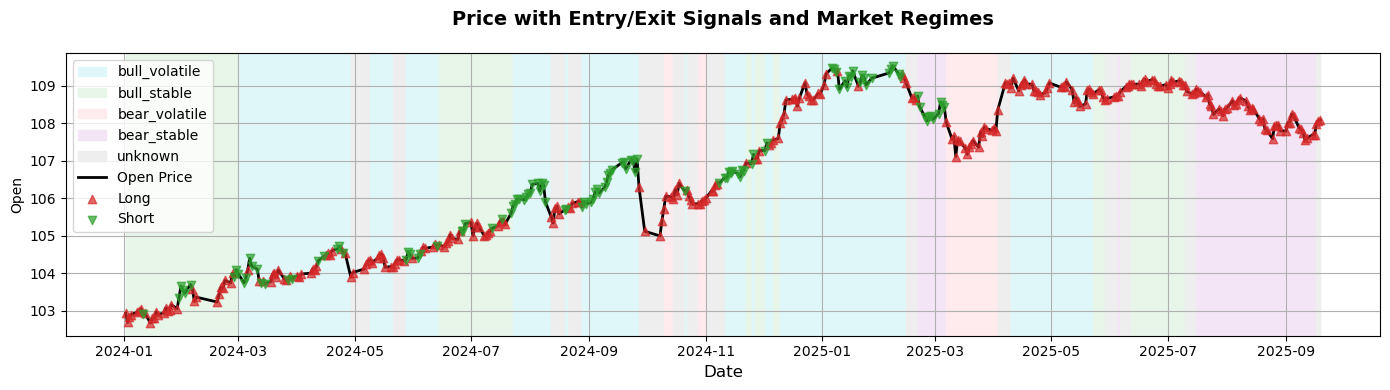

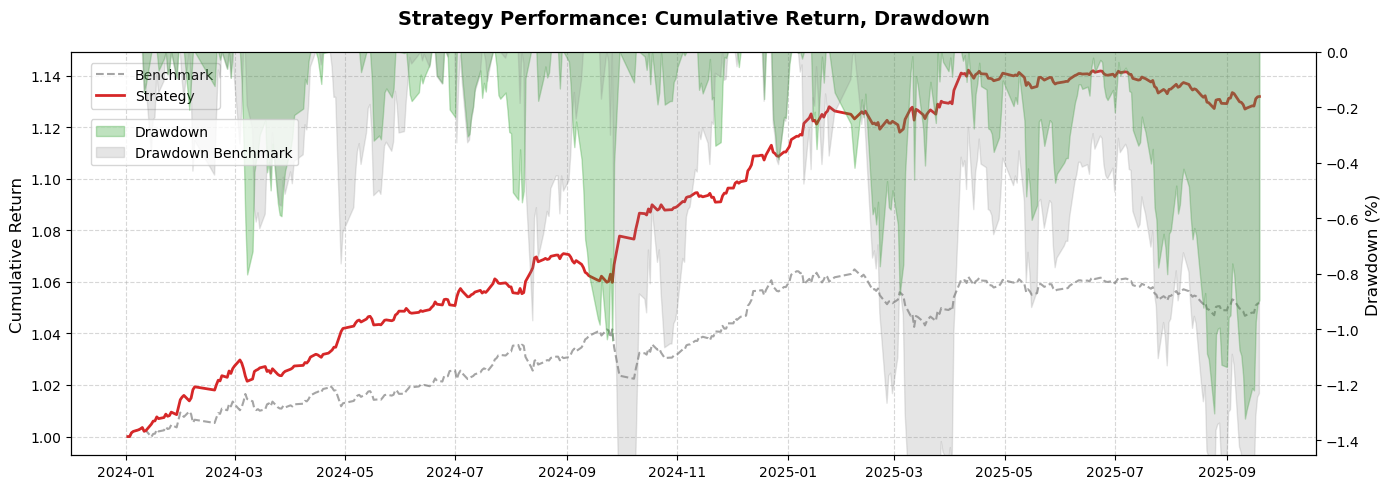

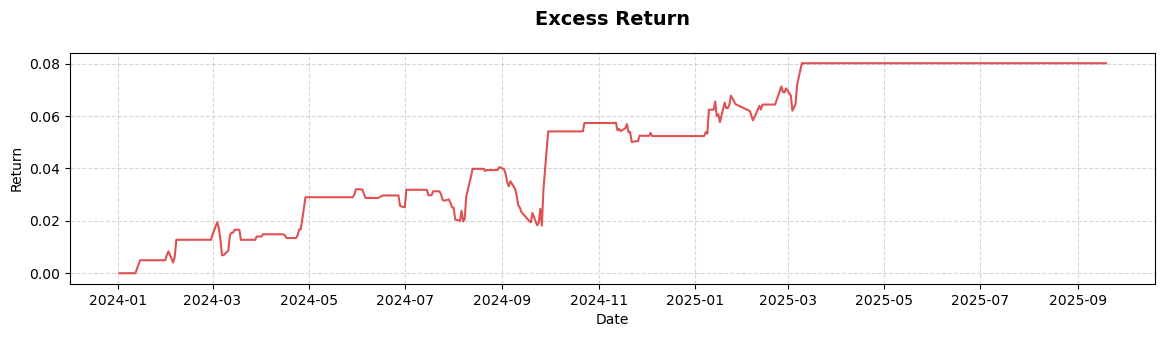

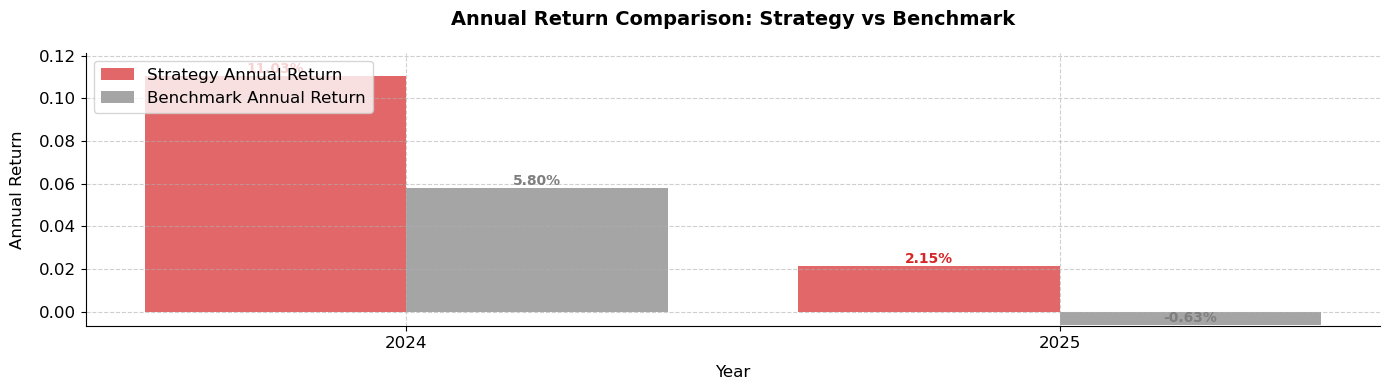

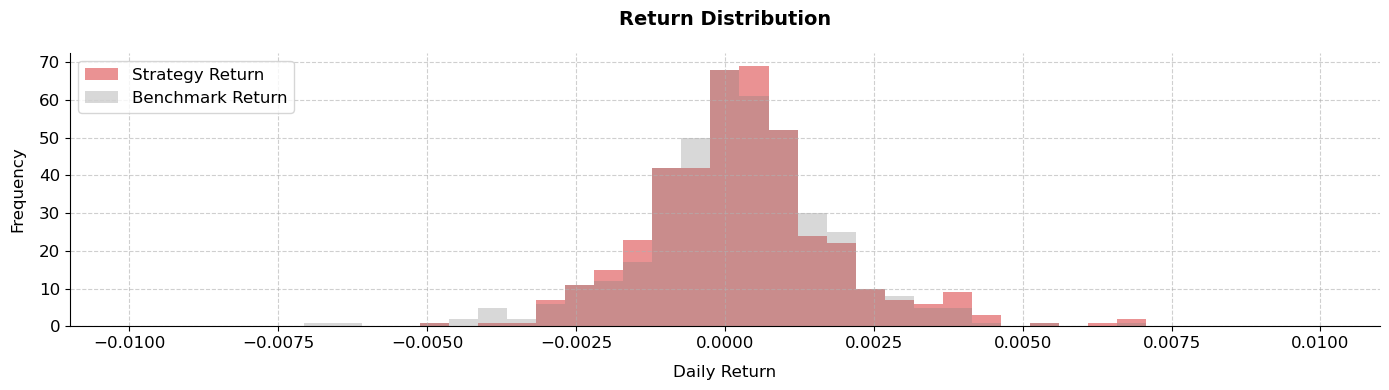

d:\mycodelife\workshop\yinhe\国债期货日频\国债期货日频\Backtrader.py:363: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sns.heatmap(monthly_returns.applymap(lambda x: x * 100),  # 转为百分比显示


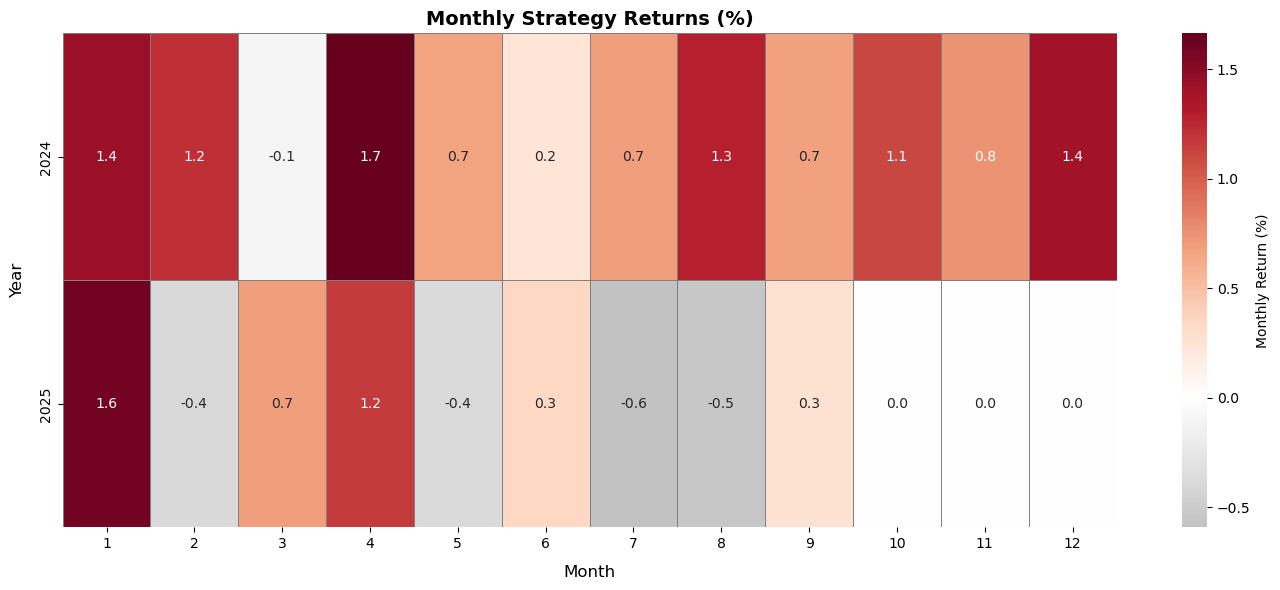

,date,combo_signal
0,2024-01-02,1
1,2024-01-03,1
2,2024-01-04,1
3,2024-01-05,1
4,2024-01-08,1
...,...,...
413,2025-09-15,1
414,2025-09-16,1
415,2025-09-17,1
416,2025-09-18,1


In [9]:
from Backtrader import StrategyBacktester
import datetime
np.random.seed(0)

#设置日期
test_start_year =2024
test_end_year = 2025

backtester = StrategyBacktester(final_signal, 
                                start_year=test_start_year, 
                                end_year=test_end_year, 
                                signal_column='combo_signal',
                                price_column='open', 
                                initial_capital=1e9, 
                                rf=0., 
                                slippage=0.
                                )

# 执行回测
backtester.run_backtest()

# 可视化价格与信号点
backtester.plot_price_with_signals()

# 可视化策略 vs 基准净值
backtester.plot_pnl_curve()
backtester.plot_monthly_heatmap_by_year()
display(backtester.result[['date','combo_signal']])

In [10]:
summary_df = backtester.summarize_by_year_month_market_state()
display(summary_df[summary_df.Year==2024].set_index(['Year','Month']))

# 输出绩效指标
performance = backtester.evaluate_performance()
display(performance)

Market State  Duration    Return  Annualized Return  \
Year Month                                                         
2024 1        bull_stable        22  0.014278           0.176323   
     2        bull_stable        15  0.010890           0.199566   
     3      bull_volatile        21 -0.002006          -0.023814   
     4      bull_volatile        18  0.008318           0.122957   
     4            unknown         2  0.001110           0.149982   
     5      bull_volatile        12  0.003303           0.071711   
     5            unknown         8  0.001985           0.064441   
     6        bull_stable        11  0.002235           0.052481   
     6      bull_volatile         8 -0.000090          -0.002827   
     7        bull_stable        16  0.008096           0.135408   
     7      bull_volatile         7 -0.002892          -0.099005   
     8      bull_volatile        12  0.012195           0.289871   
     8            unknown        10  0.006063           0.164538   
     9      bull_volatile        17 -0.010066          -0.139267   
     9            unknown         2  0.010407           2.685874   
     10     bear_volatile         7  0.005064           0.199441   
     10           unknown        10  0.010446           0.299366   
     11       bull_stable         4  0.005011           0.370127   
     11     bull_volatile        11 -0.001078          -0.024408   
     11           unknown         6  0.003504           0.158255   
     12       bull_stable         2  0.000381           0.049141   
     12     bull_volatile        20  0.012737           0.172892   

            Max Drawdown  Win Rate  
Year Month                          
2024 1         -0.001450  0.800000  
     2         -0.002093  0.666667  
     3         -0.008026  0.571429  
     4         -0.001159  0.764706  
     4          0.000000  1.000000  
     5         -0.003202  0.750000  
     5         -0.001510  0.750000  
     6         -0.002077  0.636364  
     6         -0.001776  0.375000  
     7         -0.003055  0.687500  
     7         -0.002892  0.285714  
     8         -0.002497  0.583333  
     8         -0.001768  0.777778  
     9         -0.010066  0.235294  
     9          0.000000  1.000000  
     10        -0.000174  0.833333  
     10        -0.001904  0.500000  
     11        -0.000043  0.500000  
     11        -0.003257  0.727273  
     11        -0.000129  0.833333  
     12         0.000000  1.000000  
     12        -0.003876  0.631579

,Cummulative Return,Annual Return,Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio,Win Rate,Profit Factor
value,0.131864,0.077534,0.026236,2.955237,-0.013223,5.863547,0.578049,1.721621


,bear_s_sign,cvi_sign,ri_sign,obv_sign
annual_return,0.013596,-0.005757,-0.009323,-0.022326
standard_deviation,0.031451,0.031460,0.031457,0.031431
max_drawdown,-0.023827,-0.032223,-0.024429,-0.030642


,bear_s_sign,cvi_sign,ri_sign,obv_sign
annual_return,0.080292,0.028958,0.046621,0.018914
standard_deviation,0.023715,0.024184,0.023545,0.024224
max_drawdown,-0.012033,-0.012033,-0.022815,-0.010260


,bull_s_sign,apo_sign,mom_sign,cmo_signal,rsi_sign
annual_return,0.076797,0.054516,0.049708,-0.027640,0.018332
standard_deviation,0.036669,0.032397,0.036854,0.032659,0.036970
max_drawdown,-0.017809,-0.014790,-0.017256,-0.033643,-0.045777


,bull_s_sign,apo_sign,mom_sign,cmo_signal,rsi_sign
annual_return,0.057924,0.014875,0.043406,0.021545,0.033791
standard_deviation,0.026671,0.026696,0.026645,0.022651,0.026836
max_drawdown,-0.023297,-0.026786,-0.023297,-0.013186,-0.023297


,bull_v_sign,tema_sign,cmf_sign,vhf_sign
annual_return,0.034154,-0.029577,0.025344,0.009316
standard_deviation,0.040387,0.040402,0.040413,0.039762
max_drawdown,-0.021109,-0.034244,-0.029638,-0.051925


,bull_v_sign,tema_sign,cmf_sign,vhf_sign
annual_return,0.045804,0.015572,0.037539,0.008813
standard_deviation,0.027015,0.027152,0.027066,0.021555
max_drawdown,-0.013465,-0.016741,-0.019463,-0.020650


,bear_v_sign,bb_width_signal,roc_sign,cmf_sign
annual_return,0.051282,-0.026725,0.032323,-0.096792
standard_deviation,0.043045,0.037928,0.043118,0.041978
max_drawdown,-0.024965,-0.043278,-0.030970,-0.066909


,bear_v_sign,bb_width_signal,roc_sign,cmf_sign
annual_return,0.148229,0.022780,0.079203,0.009100
standard_deviation,0.035022,0.020741,0.035910,0.036255
max_drawdown,-0.009702,-0.006855,-0.016704,-0.022347


,normal_sign,cmf_sign,ao_sign,cvi_sign
annual_return,0.108802,0.095119,0.019186,0.032668
standard_deviation,0.032038,0.032211,0.032745,0.032250
max_drawdown,-0.014559,-0.019475,-0.041323,-0.033172


,normal_sign,cmf_sign,ao_sign,cvi_sign
annual_return,0.055074,0.035364,0.043501,-0.019333
standard_deviation,0.025594,0.025733,0.025683,0.025801
max_drawdown,-0.013342,-0.015286,-0.017629,-0.029814


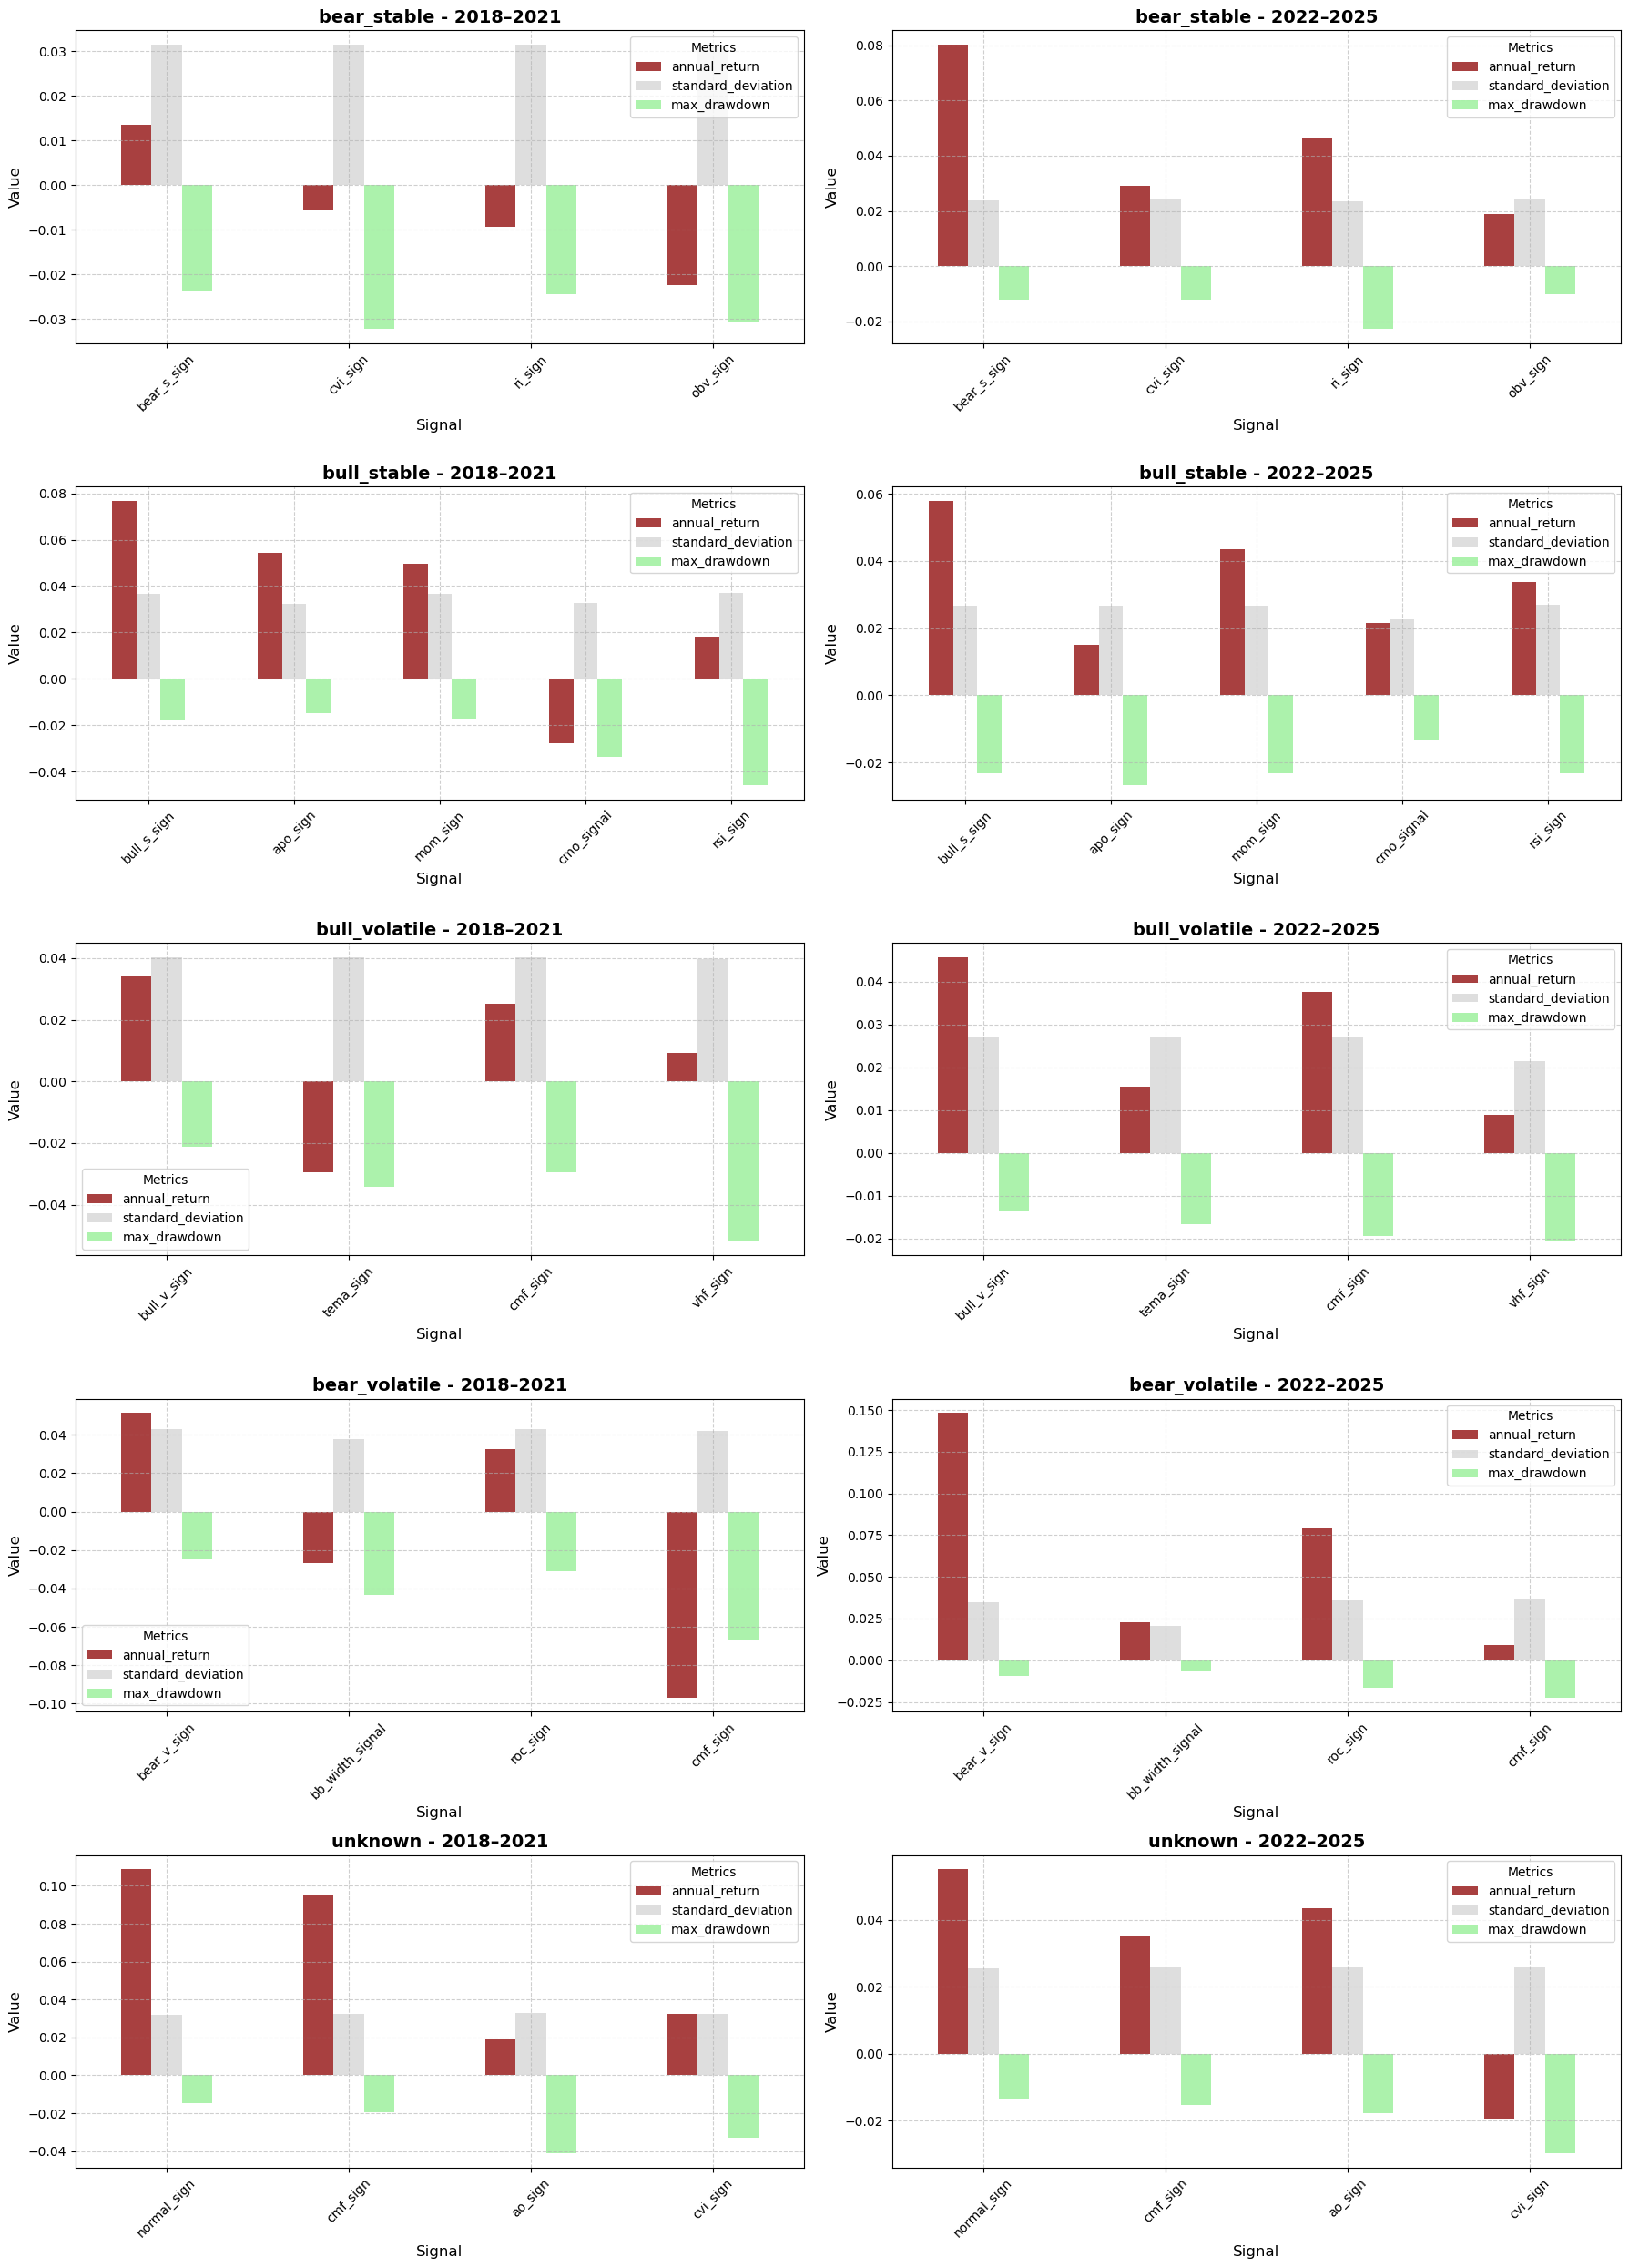

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 计算累计收益率
def calculate_cumulative_returns(data):
    data['cumulative_return'] = (1 + data['return']).cumprod()
    return data

# 计算最大回撤
def calculate_max_drawdown(data):
    data['peak'] = data['cumulative_return'].cummax()
    data['drawdown'] = (data['cumulative_return'] - data['peak']) / data['peak']
    return data['drawdown'].min()

# 计算夏普比率
def calculate_sharpe_ratio(data, rf=0):
    excess_returns = data['return'] - rf
    return np.sqrt(252) * excess_returns.mean() / excess_returns.std()

# 评估函数，增加年份区间
def evaluate_signals(final_signal, market_state, signals, year_start, year_end, price_column='open', rf=0):
    results = {}
    final_data = final_signal[(final_signal.date.dt.year >= year_start) & (final_signal.date.dt.year <= year_end)]

    for signal in signals:
        signal_data = final_data.copy()
        signal_data['signal'] = signal_data[signal]
        signal_data['return'] = signal_data[price_column].pct_change().shift(-2) * signal_data['signal']
        signal_data = signal_data[['date', 'signal', 'return', 'market_state_v2']]
        signal_data = signal_data[signal_data['market_state_v2'] == market_state]

        if signal_data.empty:
            results[signal] = {
                'annual_return': np.nan,
                'standard_deviation': np.nan,
                'max_drawdown': np.nan
            }
            continue

        signal_data = calculate_cumulative_returns(signal_data)
        results[signal] = {
            'annual_return': signal_data['return'].mean() * 252,
            'standard_deviation': signal_data['return'].std() * np.sqrt(252),
            'max_drawdown': calculate_max_drawdown(signal_data)
        }
    
    return pd.DataFrame(results)

# 市场状态和信号字典
market_states = ['bear_stable', 'bull_stable', 'bull_volatile', 'bear_volatile', 'unknown']
signal_dict = {
    'bear_stable': ['bear_s_sign', 'cvi_sign', 'ri_sign', 'obv_sign'],
    'bull_stable': ['bull_s_sign', 'apo_sign', 'mom_sign', 'cmo_signal', 'rsi_sign'],
    'bull_volatile': ['bull_v_sign', 'tema_sign', 'cmf_sign', 'vhf_sign'],
    'bear_volatile': ['bear_v_sign', 'bb_width_signal', 'roc_sign', 'cmf_sign'],
    'unknown': ['normal_sign', 'cmf_sign', 'ao_sign', 'cvi_sign']
}

# 设置画布
fig, axes = plt.subplots(len(market_states), 2, figsize=(18, 5 * len(market_states)))
colors = ['#8B0000', '#D3D3D3', '#90EE90']
time_ranges = [(2018, 2021), (2022, 2025)]
time_labels = ['2018–2021', '2022–2025']

# 绘图
for i, market_state in enumerate(market_states):
    signals = signal_dict[market_state]
    for j, (start_year, end_year) in enumerate(time_ranges):
        performance_results = evaluate_signals(final_signal, market_state, signals, start_year, end_year)
        all_results = performance_results.T
        display(performance_results)
        ax = axes[i, j]
        all_results.plot(kind='bar', ax=ax, color=colors, alpha=0.75)
        ax.set_title(f'{market_state} - {time_labels[j]}', fontsize=14, fontweight='bold')
        ax.set_ylabel('Value', fontsize=12)
        ax.set_xlabel('Signal', fontsize=12)
        ax.tick_params(axis='x', labelrotation=45, labelsize=10)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend(title='Metrics', fontsize=10)

plt.tight_layout()
plt.show()


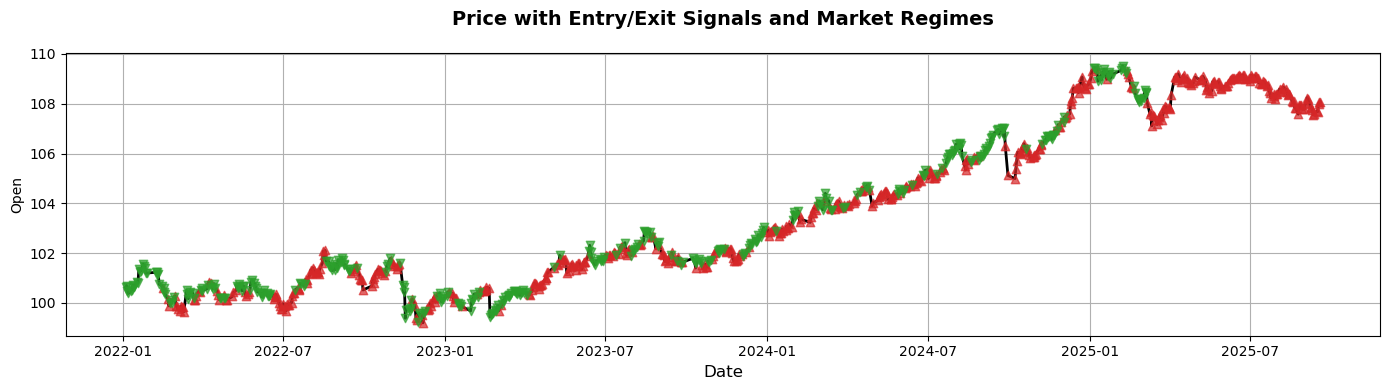

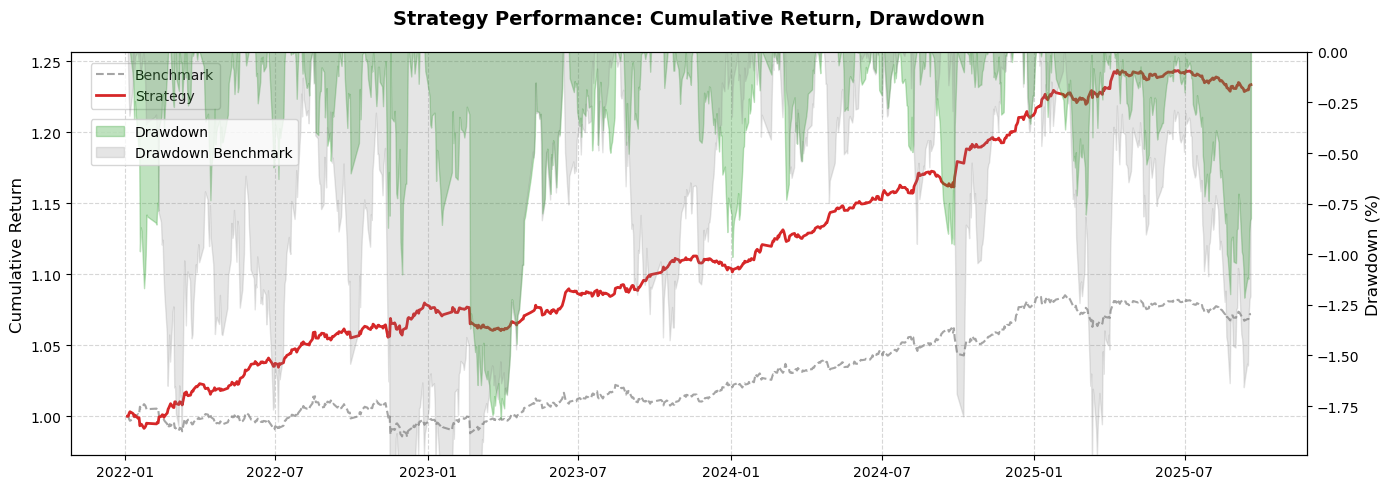

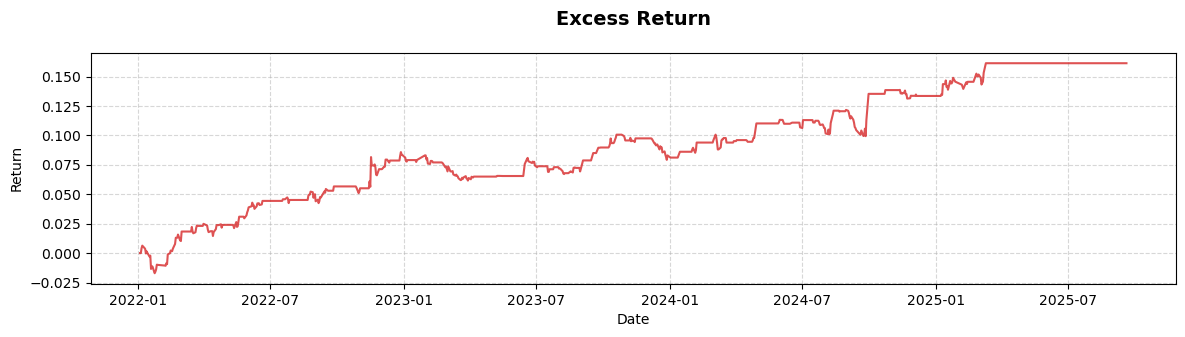

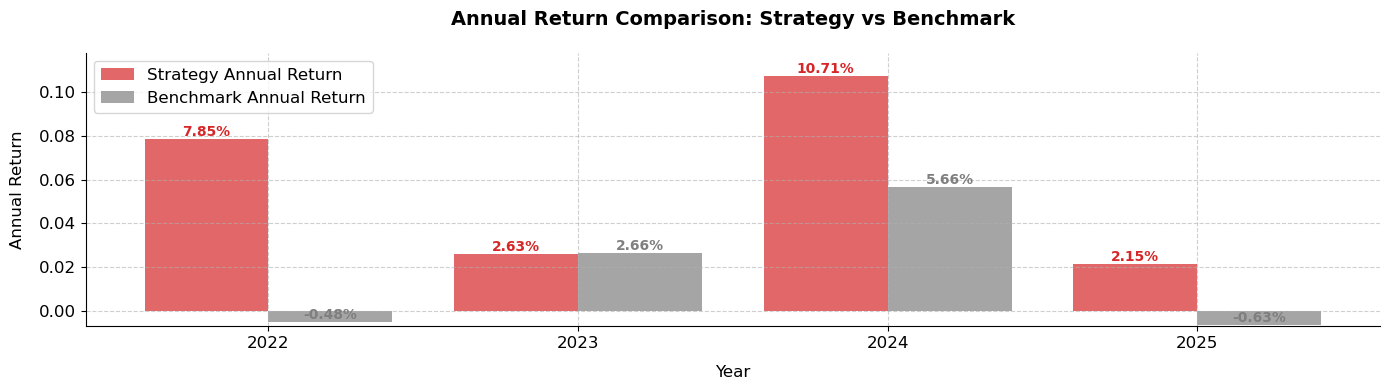

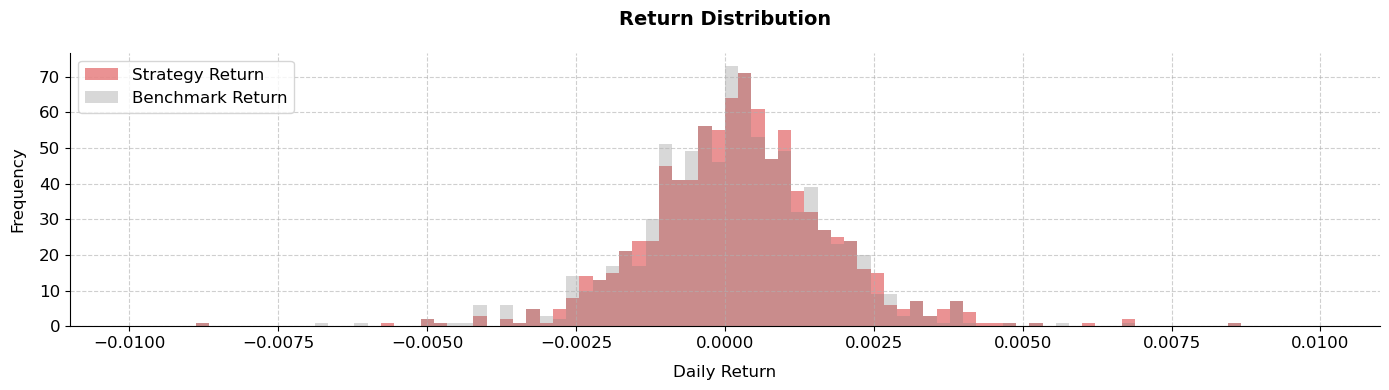

d:\mycodelife\workshop\yinhe\国债期货日频\国债期货日频\Backtrader.py:363: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sns.heatmap(monthly_returns.applymap(lambda x: x * 100),  # 转为百分比显示


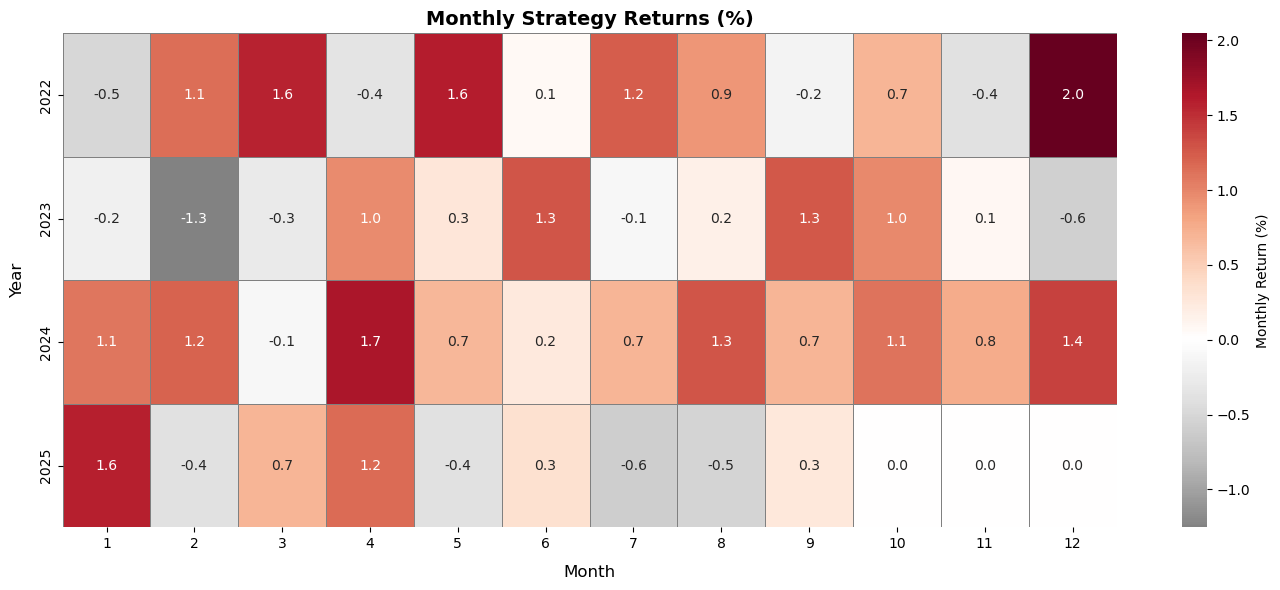

,Cummulative Return,Annual Return,Volatility,Sharpe Ratio,Max Drawdown,Calmar Ratio,Win Rate,Profit Factor
value,0.233404,0.060359,0.027062,2.230407,-0.018117,3.331613,0.572072,1.543344


In [12]:
file_path = f'signal_data_T.csv'# 如果文件已存在，加载已保存的数据
TL_data = pd.read_csv(file_path)
TL_data['date'] = pd.to_datetime(TL_data.date)
TL_signal = final_signal[['date','combo_signal','rsi_sign']].merge(
    TL_data, 
    left_on='date', 
    right_on='date', 
    how='inner',  # 'inner' 保证只保留那些在两个 DataFrame 中都有的日期
)


#设置日期
test_start_year =2022
test_end_year = 2025

backtester = StrategyBacktester(TL_signal, 
                                start_year=test_start_year, 
                                end_year=test_end_year, 
                                signal_column='combo_signal',
                                price_column='open', 
                                initial_capital=1e9, 
                                rf=0., 
                                slippage=0.
                                )

# 执行回测
backtester.run_backtest()

# 可视化价格与信号点
backtester.plot_price_with_signals()

# 可视化策略 vs 基准净值
backtester.plot_pnl_curve()
backtester.plot_monthly_heatmap_by_year()
display(backtester.evaluate_performance())

### 参数优化

In [13]:
'''import numpy as np
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor
from Backtrader import StrategyBacktester

# 初始化数据存储，用于存储每个 top_n_list 对应的 Annual Return
top_n_values = []  # 存储top_n_list组合
annual_returns = []  # 存储每个组合的年化回报
analysis_sign = 'Annual Return'


# 遍历不同的 top_n_list 组合
for window_ma in range(5,252,5):
    for vol_window in range(5, 252, 5):
                
                # 运行因子筛选和生成新信号
                df1 = get_market_state(merged_signal,window_ma=window_ma,vol_window=vol_window)
                df = combine_signals(df1)
                # 执行回测
                backtester = StrategyBacktester(df, 
                                                start_year=2022, 
                                                end_year=2025, 
                                                signal_column='combo_signal',
                                                price_column='open', 
                                                initial_capital=1e9, 
                                                rf=0., 
                                                slippage=0.)
                backtester.run_backtest()
                
                # 获取年化回报
                annual_return = backtester.evaluate_performance()[analysis_sign]
                
                
                # 存储 top_n_list 和对应的 Annual Return
                top_n_values.append([window_ma, vol_window])  # 选择 top_n[0] 和 top_n[1] 作为 X 和 Y 坐标
                annual_returns.append(annual_return)

# 将数据转换为 numpy 数组进行三维绘制
top_n_values = np.array(top_n_values)
annual_returns = np.array(annual_returns)
'''


"import numpy as np\nimport concurrent.futures\nfrom concurrent.futures import ThreadPoolExecutor\nfrom Backtrader import StrategyBacktester\n\n# 初始化数据存储，用于存储每个 top_n_list 对应的 Annual Return\ntop_n_values = []  # 存储top_n_list组合\nannual_returns = []  # 存储每个组合的年化回报\nanalysis_sign = 'Annual Return'\n\n\n# 遍历不同的 top_n_list 组合\nfor window_ma in range(5,252,5):\n    for vol_window in range(5, 252, 5):\n\n                # 运行因子筛选和生成新信号\n                df1 = get_market_state(merged_signal,window_ma=window_ma,vol_window=vol_window)\n                df = combine_signals(df1)\n                # 执行回测\n                backtester = StrategyBacktester(df, \n                                                start_year=2022, \n                                                end_year=2025, \n                                                signal_column='combo_signal',\n                                                price_column='open', \n                                                initial_capital=1e9

In [14]:
'''
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import cm

import matplotlib.pyplot as plt

# 提取 x, y, z 数据
x = top_n_values[:, 0]
y = top_n_values[:, 1]
z = annual_returns.flatten()  # 将 z 数据展平为一维数组

# 创建 3D 图形
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 设置柱状图的宽度
dx = dy = 1.2  # x 和 y 方向的柱宽
dz = z  # z 方向的高度

# 使用颜色映射，根据 z 值设置颜色
norm = plt.Normalize(z.min(), z.max())
colors = cm.viridis(norm(z))  # 使用 viridis 颜色映射

# 绘制 3D 柱状图
ax.bar3d(x - dx*3, y - dy*3, np.zeros_like(z), dx, dy, dz, color=colors, shade=True)

# 添加颜色条
sm = cm.ScalarMappable(cmap=cm.viridis, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.6, aspect=10)
cbar.set_label('Annual Return')

# 设置坐标轴标签
ax.set_xlabel('Window Ma')
ax.set_ylabel('Vol Window')
ax.set_zlabel('Annual Return')
ax.set_title('3D Bar Chart - Annual Return')

# 显示图形
plt.show()
'''

"\nfrom mpl_toolkits.mplot3d import Axes3D\nimport numpy as np\nfrom matplotlib import cm\n\nimport matplotlib.pyplot as plt\n\n# 提取 x, y, z 数据\nx = top_n_values[:, 0]\ny = top_n_values[:, 1]\nz = annual_returns.flatten()  # 将 z 数据展平为一维数组\n\n# 创建 3D 图形\nfig = plt.figure(figsize=(12, 8))\nax = fig.add_subplot(111, projection='3d')\n\n# 设置柱状图的宽度\ndx = dy = 1.2  # x 和 y 方向的柱宽\ndz = z  # z 方向的高度\n\n# 使用颜色映射，根据 z 值设置颜色\nnorm = plt.Normalize(z.min(), z.max())\ncolors = cm.viridis(norm(z))  # 使用 viridis 颜色映射\n\n# 绘制 3D 柱状图\nax.bar3d(x - dx*3, y - dy*3, np.zeros_like(z), dx, dy, dz, color=colors, shade=True)\n\n# 添加颜色条\nsm = cm.ScalarMappable(cmap=cm.viridis, norm=norm)\nsm.set_array([])\ncbar = fig.colorbar(sm, ax=ax, shrink=0.6, aspect=10)\ncbar.set_label('Annual Return')\n\n# 设置坐标轴标签\nax.set_xlabel('Window Ma')\nax.set_ylabel('Vol Window')\nax.set_zlabel('Annual Return')\nax.set_title('3D Bar Chart - Annual Return')\n\n# 显示图形\nplt.show()\n"

In [15]:
'''
import numpy as np
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor
from Backtrader import StrategyBacktester

# 初始化数据存储，用于存储每个 top_n_list 对应的 Annual Return
top_n_values = []  # 存储top_n_list组合
annual_returns = []  # 存储每个组合的年化回报
analysis_sign = 'Annual Return'


# 遍历不同的 top_n_list 组合
for window_ma in range(5,252):
    for trend_days in range(1, 20, 2):
                
                # 运行因子筛选和生成新信号
                df1 = get_market_state(merged_signal,window_ma=window_ma, trend_days=trend_days)
                df = combine_signals(df1)
                # 执行回测
                backtester = StrategyBacktester(df, 
                                                start_year=2022, 
                                                end_year=2025, 
                                                signal_column='combo_signal',
                                                price_column='open', 
                                                initial_capital=1e9, 
                                                rf=0., 
                                                slippage=0.)
                backtester.run_backtest()
                
                # 获取年化回报
                annual_return = backtester.evaluate_performance()[analysis_sign]
                
                
                # 存储 top_n_list 和对应的 Annual Return
                top_n_values.append([window_ma, trend_days])  # 选择 top_n[0] 和 top_n[1] 作为 X 和 Y 坐标
                annual_returns.append(annual_return)

# 将数据转换为 numpy 数组进行三维绘制
top_n_values = np.array(top_n_values)
annual_returns = np.array(annual_returns)
'''

"\nimport numpy as np\nimport concurrent.futures\nfrom concurrent.futures import ThreadPoolExecutor\nfrom Backtrader import StrategyBacktester\n\n# 初始化数据存储，用于存储每个 top_n_list 对应的 Annual Return\ntop_n_values = []  # 存储top_n_list组合\nannual_returns = []  # 存储每个组合的年化回报\nanalysis_sign = 'Annual Return'\n\n\n# 遍历不同的 top_n_list 组合\nfor window_ma in range(5,252):\n    for trend_days in range(1, 20, 2):\n\n                # 运行因子筛选和生成新信号\n                df1 = get_market_state(merged_signal,window_ma=window_ma, trend_days=trend_days)\n                df = combine_signals(df1)\n                # 执行回测\n                backtester = StrategyBacktester(df, \n                                                start_year=2022, \n                                                end_year=2025, \n                                                signal_column='combo_signal',\n                                                price_column='open', \n                                                initial_capital=1e9

In [16]:
'''
#----------------------------------------------------

from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import cm

import matplotlib.pyplot as plt

# 提取 x, y, z 数据
x = top_n_values[:, 0]
y = top_n_values[:, 1]
z = annual_returns.flatten()  # 将 z 数据展平为一维数组

# 创建 3D 图形
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 设置柱状图的宽度
dx = dy = 0.3  # x 和 y 方向的柱宽
dz = z  # z 方向的高度

# 使用颜色映射，根据 z 值设置颜色
norm = plt.Normalize(z.min(), z.max())
colors = cm.magma(norm(z))  # 使用 viridis 颜色映射

# 绘制 3D 柱状图
ax.bar3d(x - dx, y - dy, np.zeros_like(z), dx, dy, dz, color=colors, shade=True)

# 添加颜色条
sm = cm.ScalarMappable(cmap=cm.magma, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.6, aspect=10)
cbar.set_label('Annual Return')

# 设置坐标轴标签
ax.set_xlabel('Window Ma')
ax.set_ylabel('Trend Days')
ax.set_zlabel('Annual Return')
ax.set_title('3D Bar Chart - Annual Return')

# 显示图形
plt.show()
'''

"\n#----------------------------------------------------\n\nfrom mpl_toolkits.mplot3d import Axes3D\nimport numpy as np\nfrom matplotlib import cm\n\nimport matplotlib.pyplot as plt\n\n# 提取 x, y, z 数据\nx = top_n_values[:, 0]\ny = top_n_values[:, 1]\nz = annual_returns.flatten()  # 将 z 数据展平为一维数组\n\n# 创建 3D 图形\nfig = plt.figure(figsize=(12, 8))\nax = fig.add_subplot(111, projection='3d')\n\n# 设置柱状图的宽度\ndx = dy = 0.3  # x 和 y 方向的柱宽\ndz = z  # z 方向的高度\n\n# 使用颜色映射，根据 z 值设置颜色\nnorm = plt.Normalize(z.min(), z.max())\ncolors = cm.magma(norm(z))  # 使用 viridis 颜色映射\n\n# 绘制 3D 柱状图\nax.bar3d(x - dx, y - dy, np.zeros_like(z), dx, dy, dz, color=colors, shade=True)\n\n# 添加颜色条\nsm = cm.ScalarMappable(cmap=cm.magma, norm=norm)\nsm.set_array([])\ncbar = fig.colorbar(sm, ax=ax, shrink=0.6, aspect=10)\ncbar.set_label('Annual Return')\n\n# 设置坐标轴标签\nax.set_xlabel('Window Ma')\nax.set_ylabel('Trend Days')\nax.set_zlabel('Annual Return')\nax.set_title('3D Bar Chart - Annual Return')\n\n# 显示图形\nplt.show()\n"